In [1]:
import os, sys, copy
sys.path.insert(0, '../../')
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.notebook import trange
import time, GPy
from sklearn.preprocessing import StandardScaler

from kernels.nn import ImplicitDenseNetKernel
from model.ick import ICK
from model.ick_cmgp import ICK_CMGP
from benchmarks.cmgp_modified import CMGP
from utils.train import CMGPEnsembleTrainer
from utils.losses import *
from utils.helpers import *

# To make this notebook's output stable across runs
np.random.seed(2020)
torch.manual_seed(2020)
torch.cuda.manual_seed(2020)
torch.cuda.manual_seed_all(2020)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

<frozen importlib._bootstrap>:228: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# 1. Load and preprocess data

In [2]:
def load_and_preprocess_data(N_train, N_test):
    train_dir = '../../data/ACIC_challenge/high_dimensional_datasets/high1601.csv'
    train_df = pd.read_csv(train_dir)
    test_dir = '../../data/ACIC_challenge/TestDatasets_highD/highDim_testdataset1.csv'
    test_df = pd.read_csv(test_dir)
    test_eval_dir = '../../data/ACIC_challenge/TestDatasets_highD_cf/highDim_testdataset1_cf.csv'
    test_eval_df = pd.read_csv(test_eval_dir)
    for c in train_df.columns:
        if c != 'Y' and c != 'A':
            scaler = StandardScaler()
            train_df[c] = scaler.fit_transform(train_df[c].to_numpy().reshape(-1,1)).reshape(-1)
    for c in test_df.columns:
        if c != 'Y' and c != 'A':
            scaler = StandardScaler()
            test_df[c] = scaler.fit_transform(test_df[c].to_numpy().reshape(-1,1)).reshape(-1)

    # Training data
    X_train = train_df.to_numpy()[:N_train, 2:]
    T_train = train_df.to_numpy()[:N_train, 1][:,None]
    Y_train = train_df.to_numpy()[:N_train, 0][:,None]

    # Test data
    X_test = test_df.to_numpy()[:N_test, 2:]
    T_test = test_df.to_numpy()[:N_test, 1][:,None]
    Y_test = test_df.to_numpy()[:N_test, 0][:,None]
    mu0_test = test_eval_df.to_numpy()[:N_test, -1][:,None]
    mu1_test = test_eval_df.to_numpy()[:N_test, -2][:,None]
    mu_test = mu1_test - mu0_test
    data = {'X_train': X_train, 'T_train': T_train, 'Y_train': Y_train, 'X_test': X_test, 'mu_test': mu_test}

    # Initialize dataloaders
    data_train = [X_train, T_train]
    data_test = [X_test, T_test]
    data_generators = create_generators_from_data(data_train, Y_train, data_test, Y_test, 
                                                  train_batch_size=256, test_batch_size=1000)
    return data_generators, data

# 2. Define ICK-CMGP model

In [3]:
def build_ick_cmgp_ensemble(input_dim, load_weights=False):
    alpha11, alpha12, alpha13 = 1.0, 1.0, 1.0
    alpha21, alpha22, alpha23 = 1.0, 1.0, 1.0
    num_estimators = 10

    ensemble, ensemble_weights = [], {}
    for i in range(num_estimators):
        f11 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 0, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'relu'
                }
            }
        )
        f12 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 0, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'relu'
                }
            }
        )
        f13 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 0, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'relu'
                }
            }
        )
        f21 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 0, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'relu'
                }
            }
        )
        f22 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 0, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'relu'
                }
            }
        )
        f23 = ICK(
            kernel_assignment=['ImplicitDenseNetKernel'],
            kernel_params={
                'ImplicitDenseNetKernel':{
                    'input_dim': input_dim,
                    'latent_feature_dim': 512,
                    'num_blocks': 0, 
                    'num_layers_per_block': 1, 
                    'num_units': 512, 
                    'activation': 'relu'
                }
            }
        )
        if load_weights:
            f11.kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)]['f11'])
            f12.kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)]['f12'])
            f13.kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)]['f13'])
            f21.kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)]['f21'])
            f22.kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)]['f22'])
            f23.kernels[0].load_state_dict(torch.load('./checkpoints/ick_cmgp_acic.pt')['model_'+str(i+1)]['f23'])
        else:
            model_weights = {
                'f11': f11.kernels[0].state_dict(), 'f12': f12.kernels[0].state_dict(), 'f13': f13.kernels[0].state_dict(), 
                'f21': f21.kernels[0].state_dict(), 'f22': f22.kernels[0].state_dict(), 'f23': f23.kernels[0].state_dict()
            }
            ensemble_weights['model_'+str(i+1)] = model_weights
        baselearner = ICK_CMGP(
            control_components=[f11,f21], treatment_components=[f12,f22], shared_components=[f13,f23],
            control_coeffs=[alpha11,alpha21], treatment_coeffs=[alpha12,alpha22], shared_coeffs=[alpha13,alpha23], 
            coeff_trainable=True, output_binary=True
        )
        ensemble.append(baselearner)
    if not load_weights:
        if not os.path.exists('./checkpoints'):
            os.makedirs('./checkpoints')
        torch.save(ensemble_weights, './checkpoints/ick_cmgp_acic.pt')

    return ensemble

# 3. Training and evaluation of ICK-CMGP model

In [4]:
def fit_and_evaluate_ick_cmgp(ensemble, data_generators, mu_test, lr, treatment_index=1):
    # The index of "T_train" in "data_train" is 1
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    optim = 'sgd'
    optim_params = {
        'lr': lr, 
        'momentum': 0.99,
        'weight_decay': 0.00
    }
    epochs, patience = 1000, 10
    trainer = CMGPEnsembleTrainer(
        model=ensemble,
        data_generators=data_generators,
        optim=optim,
        optim_params=optim_params, 
        model_save_dir=None,
        device=device,
        epochs=epochs,
        patience=patience, 
        treatment_index=treatment_index
    )
    train_start = time.time()
    trainer.train()
    train_time = time.time() - train_start
    
    mean_test_pred, std_test_pred, y_test_true = trainer.predict()
    mu_test_pred = mean_test_pred[:,1] - mean_test_pred[:,0]
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (ICK-CMGP):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 4. Apply original CMGP framework on the same dataset

In [5]:
def fit_and_evaluate_original_cmgp(data):
    X_train, T_train, Y_train = data['X_train'], data['T_train'], data['Y_train']
    X_test, mu_test = data['X_test'], data['mu_test']
#     K0 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.1, bias_variance=0.1, ARD=False)
#     K1 = GPy.kern.MLP(X_train.shape[1], weight_variance=0.2, bias_variance=0.2, ARD=False)
    train_start = time.time()
    cmgp_model = CMGP(X_train, T_train, Y_train)
    train_time = time.time() - train_start
    
    mu0_test_pred, mu1_test_pred = cmgp_model.predict(X_test, return_var=False)
    mu_test_pred = mu1_test_pred - mu0_test_pred
    pehe_test = np.sqrt(np.mean((mu_test_pred - mu_test) ** 2))
    print('PEHE (CMGP):             %.4f' % (pehe_test))
    
    return pehe_test, train_time

# 5. Main function

In [ ]:
def main():
    N_train = [100,200,300,400,500,1000,1500,2000]
    N_test = [2000] * len(N_train)
    lrs = [1e-3,8e-4,6e-4,6e-4,6e-4,2e-4,1.5e-4,1e-4]
    res = {k: {} for k in N_train}
    for i in trange(len(N_train)):
        data_generators, data = load_and_preprocess_data(N_train[i], N_test[i])
        input_dim = data['X_train'].shape[1]
        # Make sure the ICK-CMGP ensemble has the same starting point for each experimental run
        ensemble = build_ick_cmgp_ensemble(input_dim, load_weights=(i!=0))
        sqrt_pehe_ick_cmgp, train_time_ick_cmgp = fit_and_evaluate_ick_cmgp(
            ensemble, data_generators, data['mu_test'], lr=lrs[i])
        res[N_train[i]]['sqrt_pehe_ick_cmgp'] = sqrt_pehe_ick_cmgp
        res[N_train[i]]['train_time_ick_cmgp'] = train_time_ick_cmgp
        sqrt_pehe_cmgp, train_time_cmgp = fit_and_evaluate_original_cmgp(data)
        res[N_train[i]]['sqrt_pehe_cmgp'] = sqrt_pehe_cmgp
        res[N_train[i]]['train_time_cmgp'] = train_time_cmgp
    if not os.path.exists('./Results'):
        os.makedirs('./results')
    with open('./results/acic_challenge_results.pkl', 'wb') as fp:
        pkl.dump(res, fp)

if __name__ == "__main__":
    main()

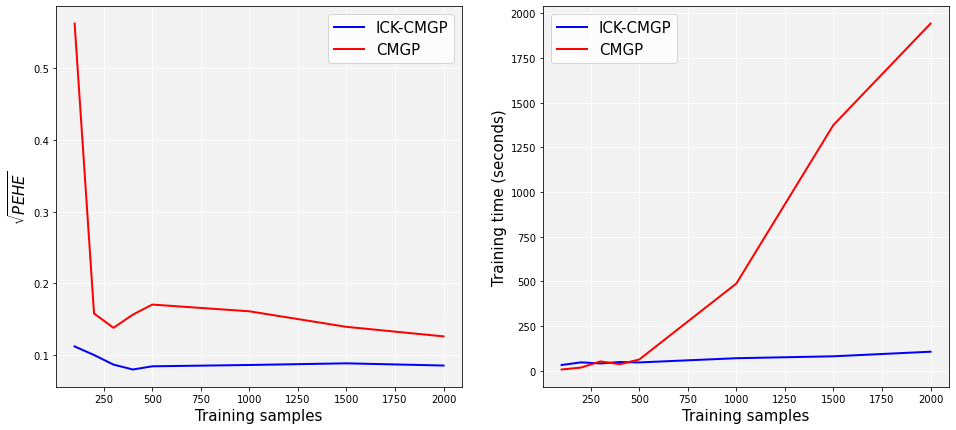

In [9]:
with open('./results/acic_challenge_results.pkl', 'rb') as fp:
    res = pkl.load(fp)

fig, axs = plt.subplots(1,2,figsize=(16,7))
training_samples = list(res.keys())
sqrt_pehe_ick_cmgp = [x['sqrt_pehe_ick_cmgp'] for x in list(res.values())]
sqrt_pehe_cmgp = [x['sqrt_pehe_cmgp'] for x in list(res.values())]
axs[0].plot(training_samples, sqrt_pehe_ick_cmgp, lw=2, color='blue', label='ICK-CMGP')
axs[0].plot(training_samples, sqrt_pehe_cmgp, lw=2, color='red', label='CMGP')
axs[0].set_xlabel('Training samples', fontsize=15)
axs[0].set_ylabel('$\sqrt{PEHE}$', fontsize=15)
axs[0].set_facecolor('#F2F2F2')
axs[0].grid(color='white')
axs[0].legend(fontsize=15)
train_time_ick_cmgp = [x['train_time_ick_cmgp'] for x in list(res.values())]
train_time_cmgp = [x['train_time_cmgp'] for x in list(res.values())]
axs[1].plot(training_samples, train_time_ick_cmgp, lw=2, color='blue', label='ICK-CMGP')
axs[1].plot(training_samples, train_time_cmgp, lw=2, color='red', label='CMGP')
axs[1].set_xlabel('Training samples', fontsize=15)
axs[1].set_ylabel('Training time (seconds)', fontsize=15)
axs[1].set_facecolor('#F2F2F2')
axs[1].grid(color='white')
axs[1].legend(fontsize=15)